In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset, base_transform, plot_psa_dim_scores
from models.video_classifier import TransformerModel_, HybridCNNTransformer
import os
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bands = 4 #밴드 수
patch_size = 9
num_epochs = 100

In [4]:
val_filters = [
    lambda x: x >= 1 and (x % 50) in {1, 6, 13, 18, 25, 30, 32, 37, 44, 49} ,
    lambda x: x >= 2 and (x % 50) in {2, 7, 14, 19, 21, 26, 33, 38, 45, 0}  ,
    lambda x: x >= 3 and (x % 50) in {3, 8, 15, 20, 22, 27, 34, 39, 41, 46},
    lambda x: x >= 4 and (x % 50) in {4, 9, 11, 16, 23, 28, 35, 40, 42, 47 }  ,
    lambda x: x >= 5 and (x % 50) in {5, 10, 12, 17, 24, 29, 31, 36, 43, 48},
]

In [5]:
idx =0
transform = base_transform(bands, patch_size)

#data loader만들기
train_dataset = TiffDataset(
    large_tif_dir = '../../data/source_data/naive',
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file ="../../data/label_data/species/label_mapping_sampled.csv",
    box_filter_fn = lambda box_number: not val_filters[idx](box_number),
    patch_size = patch_size,
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

#모델 생성, pth 업로드
model = TransformerModel_().to(device)
model.load_state_dict(torch.load(f"./checkpoints/transformer/transformer_{bands}_{patch_size}_{num_epochs}_{idx}.pth", map_location=device))

<All keys matched successfully>

In [6]:
import seaborn as sns

In [7]:
#sdi 함수
import torch
import random
from tqdm import tqdm

import torch
import random
from tqdm import tqdm

def psa_dim(model, data_loader, num_repeats=1, perturbation_strength=0.8, target_dims=None, normalize=True, TP_only=True):
    model.eval()

    sample_batch, _ = next(iter(data_loader))
    num_dims = len(sample_batch.shape) - 1
    dim_names = [f"dim_{i}" for i in range(1, num_dims + 1)]

    # 조사할 차원을 설정 (기본: 모든 차원)
    if target_dims is None:
        target_dims = dim_names
    else:
        target_dims = [f"dim_{i}" for i in target_dims]

    overall_scores = {dim: 0.0 for dim in target_dims}
    per_class_scores = {}
    TP_count = {}  # TP 개수를 저장할 딕셔너리
    total_samples = 0

    for X_batch, targets in tqdm(data_loader, desc="Processing batches"):
        batch_size = X_batch.shape[0]
        total_samples += batch_size
        X_batch = X_batch.to(next(model.parameters()).device)
        targets = targets.to(X_batch.device)

        logit_original = model(X_batch).detach()
        predictions = logit_original.argmax(dim=1)
        num_classes = logit_original.shape[1]

        if not per_class_scores:
            per_class_scores = {cls: {dim: 0.0 for dim in target_dims} for cls in range(num_classes)}
            TP_count = {cls: 0 for cls in range(num_classes)}

        for dim_name in target_dims:
            dim_idx = dim_names.index(dim_name) + 1  # 1-based index
            total_abs_error = 0.0
            class_abs_error = {cls: 0.0 for cls in range(num_classes)}

            for _ in range(num_repeats):
                X_perturbed = X_batch.clone().detach()
                num_swap = max(1, int(X_perturbed.shape[dim_idx] * perturbation_strength))
                swap_indices = random.sample(range(X_perturbed.shape[dim_idx]), num_swap)
                permutation = random.sample(swap_indices, len(swap_indices))

                X_perturbed.index_copy_(dim_idx, torch.tensor(swap_indices, device=X_batch.device),
                                        X_perturbed.index_select(dim_idx, torch.tensor(permutation, device=X_batch.device)))

                logit_perturbed = model(X_perturbed).detach()
                abs_error = torch.abs(logit_original - logit_perturbed).mean(dim=0)
                total_abs_error += abs_error.mean().item() * batch_size

                for cls in range(num_classes):
                    if TP_only:
                        TP_mask = (predictions == targets) & (targets == cls)
                        TP_sample_count = TP_mask.sum().item()
                        if TP_sample_count > 0:
                            TP_count[cls] += TP_sample_count
                            class_abs_error[cls] += abs_error[cls].item() * TP_sample_count
                    else:
                        class_abs_error[cls] += abs_error[cls].item() * batch_size

            overall_scores[dim_name] += total_abs_error / num_repeats
            for cls in range(num_classes):
                per_class_scores[cls][dim_name] += class_abs_error[cls] / num_repeats

    for key in overall_scores:
        overall_scores[key] /= total_samples

    for cls in per_class_scores:
        if TP_only and TP_count[cls] > 0:
            for key in per_class_scores[cls]:
                per_class_scores[cls][key] /= TP_count[cls]
        else:
            for key in per_class_scores[cls]:
                per_class_scores[cls][key] /= total_samples

    # 🔹 선택한 차원만 정규화하여 합이 1이 되도록 조정
    if normalize:
        total_score = sum(overall_scores.values())
        overall_scores = {key: value / total_score for key, value in overall_scores.items()} if total_score > 0 else overall_scores

        for cls in per_class_scores:
            class_total_score = sum(per_class_scores[cls].values())
            per_class_scores[cls] = {key: value / class_total_score for key, value in per_class_scores[cls].items()} if class_total_score > 0 else per_class_scores[cls]

    return {"overall": overall_scores, "per_class": per_class_scores}

target_name_mapping = {
    0: "NF", #Non-Forest, 비산림
    1: "PD", # Pinus densiflora, 소나무
    2: "PK", # Pinus koraiensis, 잣나무
    3: "LK", # Larix kaempferi, 낙엽송
    4: "QM", # Quercus mongolica, 신갈나무
    5: "QV" # Quercus variabilis, 굴참나무
}


def plot_psa_dim_scores(overall_scores, per_class_scores, dim_labels=["Bands", "Time", "Space"]):
    # Overall Dimension Importance (Bar Chart)
    combined_scores = {
        "Bands": overall_scores['dim_1'],
        "Time": overall_scores['dim_2'],
        "Space": overall_scores['dim_3'] + overall_scores['dim_4']
    }

    plt.figure(figsize=(8, 5))
    plt.bar(dim_labels, combined_scores.values(), color='skyblue')
    plt.xlabel("Dimension")
    plt.ylabel("Sensitivity Score")
    plt.title("Overall Dimension Sensitivity")
    plt.xticks(rotation=45)
    plt.show()

    # Per-Class Importance (Heatmap)
    per_class_df = {}
    for cls, scores in per_class_scores.items():
        per_class_df[target_name_mapping.get(cls, f"Class {cls}")] = [
            scores['dim_1'],
            scores['dim_2'],
            scores['dim_3'] + scores['dim_4']  # Space
        ]
        
    plt.figure(figsize=(10, 6))
    sns.heatmap(list(per_class_df.values()), annot=True, cmap="Blues", xticklabels=dim_labels, yticklabels=list(per_class_df.keys()))
    plt.xlabel("Dimension")
    plt.ylabel("Class")
    plt.title("Per-Class Dimension Sensitivity")
    plt.xticks(rotation=45)
    plt.show()

In [8]:
import torch
import random
from tqdm import tqdm

def psa_dim(model, data_loader, num_repeats=1, perturbation_strength=0.8, target_dims=None, normalize=True, TP_only=True):
    model.eval()

    sample_batch, _ = next(iter(data_loader))
    num_dims = len(sample_batch.shape) - 1
    dim_names = [f"dim_{i}" for i in range(1, num_dims + 1)]

    # 조사할 차원을 설정 (기본: 모든 차원)
    if target_dims is None:
        target_dims = dim_names
    else:
        target_dims = [f"dim_{i}" for i in target_dims]

    overall_scores = {dim: 0.0 for dim in target_dims}
    per_class_scores = {}
    TP_count = {}  # TP 개수를 저장할 딕셔너리
    total_samples = 0

    for X_batch, targets in tqdm(data_loader, desc="Processing batches"):
        batch_size = X_batch.shape[0]
        total_samples += batch_size
        X_batch = X_batch.to(next(model.parameters()).device)
        targets = targets.to(X_batch.device)

        logit_original = model(X_batch).detach()
        predictions = logit_original.argmax(dim=1)
        num_classes = logit_original.shape[1]

        if not per_class_scores:
            per_class_scores = {cls: {dim: 0.0 for dim in target_dims} for cls in range(num_classes)}
            TP_count = {cls: 0 for cls in range(num_classes)}

        for dim_name in target_dims:
            dim_idx = dim_names.index(dim_name) + 1  # 1-based index
            total_abs_error = 0.0
            class_abs_error = {cls: 0.0 for cls in range(num_classes)}

            for _ in range(num_repeats):
                X_perturbed = X_batch.clone().detach()
                num_swap = max(1, int(X_perturbed.shape[dim_idx] * perturbation_strength))
                swap_indices = random.sample(range(X_perturbed.shape[dim_idx]), num_swap)
                permutation = random.sample(swap_indices, len(swap_indices))

                X_perturbed.index_copy_(dim_idx, torch.tensor(swap_indices, device=X_batch.device),
                                        X_perturbed.index_select(dim_idx, torch.tensor(permutation, device=X_batch.device)))

                logit_perturbed = model(X_perturbed).detach()
                abs_error = torch.abs(logit_original - logit_perturbed)  # 원본과 변형된 예측값의 절대 차이 계산

                total_abs_error += abs_error.mean().item() * batch_size

                for cls in range(num_classes):
                    if TP_only:
                        TP_mask = (predictions == targets) & (targets == cls)
                        TP_sample_count = TP_mask.sum().item()
                        if TP_sample_count > 0:
                            TP_count[cls] += TP_sample_count
                            class_abs_error[cls] += abs_error[TP_mask].sum().item()  # TP 개별 샘플들의 에러 합산
                    else:
                        class_abs_error[cls] += abs_error[:, cls].sum().item()

            overall_scores[dim_name] += total_abs_error / num_repeats
            for cls in range(num_classes):
                per_class_scores[cls][dim_name] += class_abs_error[cls] / num_repeats

    for key in overall_scores:
        overall_scores[key] /= total_samples

    for cls in per_class_scores:
        if TP_only and TP_count[cls] > 0:
            for key in per_class_scores[cls]:
                per_class_scores[cls][key] /= TP_count[cls]  # TP 샘플 개수로 나누어 평균 계산
        else:
            for key in per_class_scores[cls]:
                per_class_scores[cls][key] /= total_samples

    # 🔹 선택한 차원만 정규화하여 합이 1이 되도록 조정
    if normalize:
        total_score = sum(overall_scores.values())
        overall_scores = {key: value / total_score for key, value in overall_scores.items()} if total_score > 0 else overall_scores

        for cls in per_class_scores:
            class_total_score = sum(per_class_scores[cls].values())
            per_class_scores[cls] = {key: value / class_total_score for key, value in per_class_scores[cls].items()} if class_total_score > 0 else per_class_scores[cls]

    return {"overall": overall_scores, "per_class": per_class_scores}


Processing batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3773/3773 [04:08<00:00, 15.21it/s]


전체 차원 중요도: {'dim_1': 0.5580569570377563, 'dim_2': 0.3924858483567644, 'dim_3': 0.023516928727329345, 'dim_4': 0.02594026587814991}
클래스별 차원 중요도:
  클래스 0: {'dim_1': 0.5496093418726673, 'dim_2': 0.33044786881059257, 'dim_3': 0.056054048370244164, 'dim_4': 0.06388874094649606}
  클래스 1: {'dim_1': 0.6235083144043106, 'dim_2': 0.32113078169651127, 'dim_3': 0.02528181643123583, 'dim_4': 0.030079087467942228}
  클래스 2: {'dim_1': 0.6397943103000943, 'dim_2': 0.31348022265216474, 'dim_3': 0.02158980722238957, 'dim_4': 0.0251356598253514}
  클래스 3: {'dim_1': 0.5608459397348331, 'dim_2': 0.4083626586931704, 'dim_3': 0.015446057567738926, 'dim_4': 0.015345344004257496}
  클래스 4: {'dim_1': 0.5036361065913545, 'dim_2': 0.4509999990107097, 'dim_3': 0.021817131616464813, 'dim_4': 0.023546762781470977}
  클래스 5: {'dim_1': 0.49731803761821786, 'dim_2': 0.46718813489404576, 'dim_3': 0.017247918334844747, 'dim_4': 0.018245909152891704}


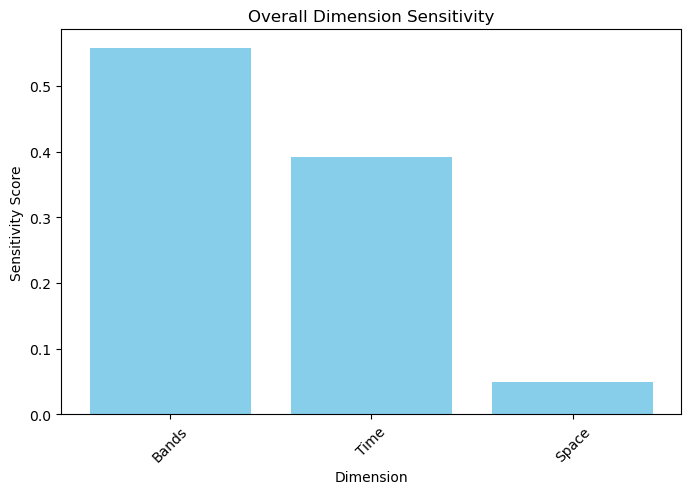

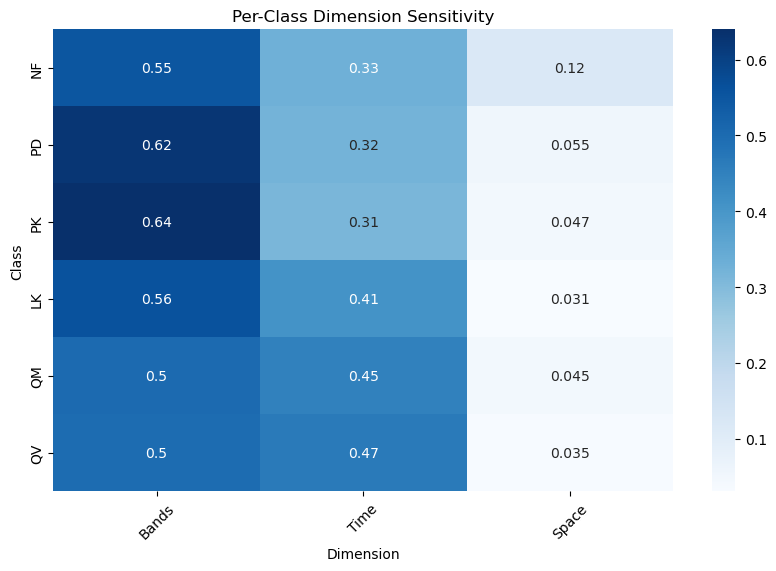

In [24]:
perturbation_scores = psa_dim(model, train_loader, num_repeats=3, perturbation_strength=0.8, normalize=True)

print("전체 차원 중요도:", perturbation_scores["overall"])
print("클래스별 차원 중요도:")
for cls, scores in perturbation_scores["per_class"].items():
    print(f"  클래스 {cls}: {scores}")
    
plot_psa_dim_scores(perturbation_scores["overall"], perturbation_scores["per_class"])

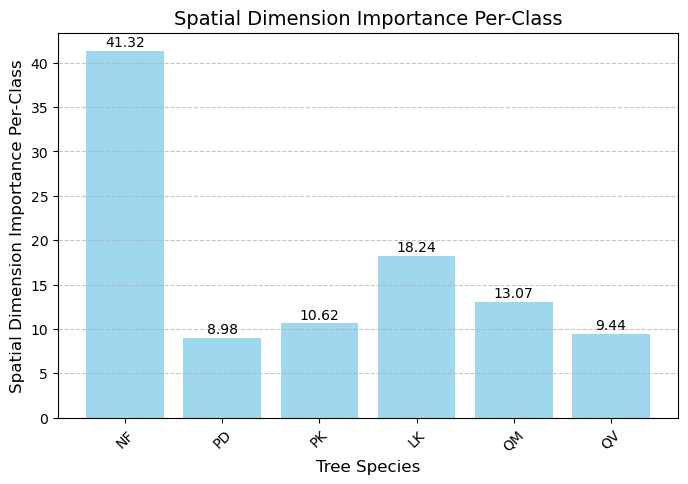

In [21]:
# 클래스명 매핑
target_name_mapping = {
    0: "NF", # Non-Forest, 비산림
    1: "PD", # Pinus densiflora, 소나무
    2: "PK", # Pinus koraiensis, 잣나무
    3: "LK", # Larix kaempferi, 낙엽송
    4: "QM", # Quercus mongolica, 신갈나무
    5: "QV"  # Quercus variabilis, 굴참나무
}

# 각 key별 dim_1과 dim_2의 합 계산
result = {key: value['dim_1'] + value['dim_2'] for key, value in perturbation_scores["per_class"].items()}

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(target_name_mapping.values(), result.values(), color='skyblue', alpha=0.8)

# 그래프 꾸미기
plt.xlabel("Tree Species", fontsize=12)
plt.ylabel("Spatial Dimension Importance Per-Class", fontsize=12)
plt.title("Spatial Dimension Importance Per-Class", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 값 표시
for i, (label, v) in enumerate(zip(target_name_mapping.values(), result.values())):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center', fontsize=10)

plt.show()

전체 차원 중요도: {'dim_2': 0.9837201922207562, 'dim_3': 0.0070056166676340645, 'dim_4': 0.009274191111609601}
클래스별 차원 중요도:
  클래스 0: {'dim_2': 0.975459769620817, 'dim_3': 0.010079831445230883, 'dim_4': 0.01446039893395213}
  클래스 1: {'dim_2': 0.9786056687114584, 'dim_3': 0.009052867226336744, 'dim_4': 0.012341464062204849}
  클래스 2: {'dim_2': 0.987625233800081, 'dim_3': 0.005731491619806514, 'dim_4': 0.006643274580112499}
  클래스 3: {'dim_2': 0.9907671685342772, 'dim_3': 0.003937110943360261, 'dim_4': 0.005295720522362467}
  클래스 4: {'dim_2': 0.9793544056120698, 'dim_3': 0.008743517499715083, 'dim_4': 0.011902076888215162}
  클래스 5: {'dim_2': 0.9836650692092174, 'dim_3': 0.007416355444400417, 'dim_4': 0.00891857534638217}


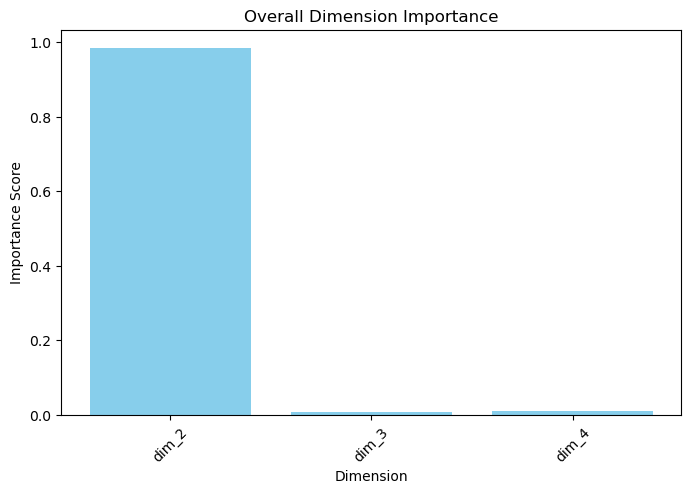

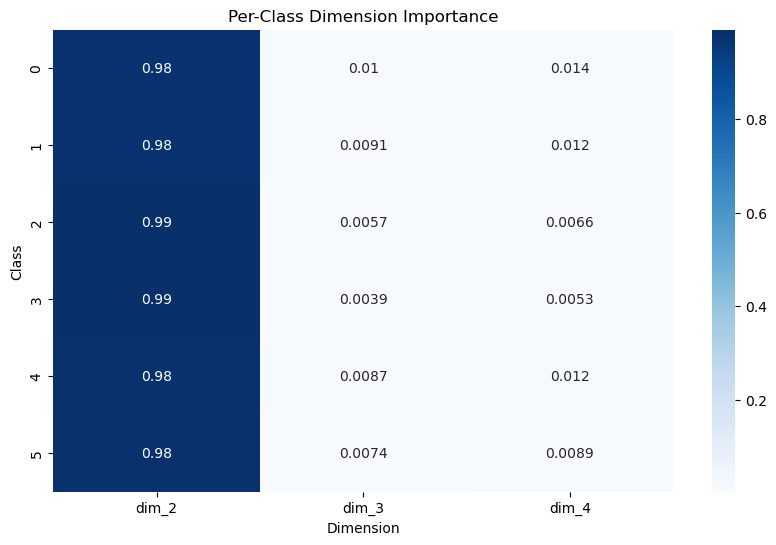

In [8]:
perturbation_scores = sdi_importance_analysis(model, train_loader, num_samples=3, perturbation_strength=0.8, target_dims=[2, 3, 4])

print("전체 차원 중요도:", perturbation_scores["overall"])
print("클래스별 차원 중요도:")
for cls, scores in perturbation_scores["per_class"].items():
    print(f"  클래스 {cls}: {scores}")
plot_importance_scores(perturbation_scores["overall"], perturbation_scores["per_class"])

In [9]:
#perturbation 관련 코드
target_name_mapping = {
    0: "NF", #Non-Forest, 비산림
    1: "PD", # Pinus densiflora, 소나무
    2: "PK", # Pinus koraiensis, 잣나무
    3: "LK", # Larix kaempferi, 낙엽송
    4: "QM", # Quercus mongolica, 신갈나무
    5: "QV" # Quercus variabilis, 굴참나무
}

# 날짜 라벨 설정
dates = ['0201', '0301', '0401', '0415', '0501', '0515', '0601', '0701', '0901', '1001', '1015', '1101']

def add_noise(data, noise_level=1.0):
    """
    데이터에 랜덤 노이즈를 추가하는 함수.

    Args:
        data (torch.Tensor): 입력 데이터 (Bands, Time, Height, Width)
        noise_level (float): 노이즈 강도 계수

    Returns:
        torch.Tensor: 노이즈가 추가된 데이터
    """
    noise = (torch.rand_like(data) * 2 - 1) * (data * noise_level)
    return data + noise

def evaluate_perturbation(model, dataloader, num_classes=6, noise_level=0.1, num_repeats=1):
    """
    모델의 교란(노이즈) 영향 평가 및 중요도 히트맵 생성 (기존 + 새로운 방법 포함)

    Args:
        model (torch.nn.Module): 학습된 모델
        dataloader (torch.utils.data.DataLoader): 데이터 로더
        num_classes (int): 클래스 개수
        noise_level (float): 노이즈 강도
        num_repeats (int): 반복 실험 횟수

    Returns:
        tuple:
            - 히트맵 (num_classes, band, time)
            - count_map (num_classes, band, time)
            - band별 중요도 (num_classes, band)
            - time별 중요도 (num_classes, time)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    band, time = 4, 12  # 데이터의 밴드 수와 시간 스텝 수

    # 결과 저장용 변수
    total_heatmap = torch.zeros((num_classes, band, time), device=device)
    total_count_map = torch.zeros((num_classes, band, time), device=device)
    total_band_importance = torch.zeros((num_classes, band), device=device)
    total_time_importance = torch.zeros((num_classes, time), device=device)

    with torch.no_grad():
        for repeat in range(num_repeats):
            heatmap = torch.zeros((num_classes, band, time), device=device)
            band_importance = torch.zeros((num_classes, band), device=device)
            time_importance = torch.zeros((num_classes, time), device=device)

            for data, labels in tqdm(dataloader, desc=f"Experiment {repeat+1}/{num_repeats}"):
                data, labels = data.to(device), labels.to(device)
                B, Band, Time, H, W = data.shape

                # 1. 원본 예측값 저장
                original_logits = model(data)
                original_preds = original_logits.argmax(dim=1)

                # 2. True Positive(TP) 마스크 생성
                tp_mask = (original_preds == labels)

                # 3. 기존 방법: band, time의 특정 값만 교란
                for b in range(band):
                    for t in range(time):
                        perturbed_data = data.clone()
                        perturbed_data[:, b, t] = add_noise(perturbed_data[:, b, t], noise_level)

                        perturbed_logits = model(perturbed_data)
                        mse_loss = F.mse_loss(original_logits, perturbed_logits, reduction='none').mean(dim=1)

                        for c in range(num_classes):
                            class_mask = (original_preds == c)
                            valid_mask = tp_mask & class_mask
                            heatmap[c, b, t] += mse_loss[valid_mask].sum()

                # 4. 새로운 방법 1️⃣: band 전체를 교란하여 중요도 측정
                for b in range(band):
                    perturbed_data = data.clone()
                    perturbed_data[:, b] = add_noise(perturbed_data[:, b], noise_level)

                    perturbed_logits = model(perturbed_data)
                    mse_loss = F.mse_loss(original_logits, perturbed_logits, reduction='none').mean(dim=1)

                    for c in range(num_classes):
                        class_mask = (original_preds == c)
                        valid_mask = tp_mask & class_mask
                        band_importance[c, b] += mse_loss[valid_mask].sum()

                # 5. 새로운 방법 2️⃣: time 전체를 교란하여 중요도 측정
                for t in range(time):
                    perturbed_data = data.clone()
                    perturbed_data[:, :, t] = add_noise(perturbed_data[:, :, t], noise_level)

                    perturbed_logits = model(perturbed_data)
                    mse_loss = F.mse_loss(original_logits, perturbed_logits, reduction='none').mean(dim=1)

                    for c in range(num_classes):
                        class_mask = (original_preds == c)
                        valid_mask = tp_mask & class_mask
                        time_importance[c, t] += mse_loss[valid_mask].sum()

            # 반복 실험 결과 누적
            total_heatmap += heatmap
            total_band_importance += band_importance
            total_time_importance += time_importance

    # 평균 내기
    total_heatmap /= num_repeats
    total_band_importance /= num_repeats
    total_time_importance /= num_repeats

    # 히트맵 정규화 (기존 방식)
    for c in range(num_classes):
        if total_heatmap[c].sum() > 0:
            total_heatmap[c] /= total_heatmap[c].sum()
            total_heatmap[c] *= (band * time)

    # 새로운 방식 정규화 (band, time 각각 정규화)
    for c in range(num_classes):
        if total_band_importance[c].sum() > 0:
            total_band_importance[c] /= total_band_importance[c].sum()
            total_band_importance[c] *= band

        if total_time_importance[c].sum() > 0:
            total_time_importance[c] /= total_time_importance[c].sum()
            total_time_importance[c] *= time

    return (
        total_heatmap.cpu().numpy(),  # (num_classes, band, time)
        total_band_importance.cpu().numpy(),  # (num_classes, band)
        total_time_importance.cpu().numpy()  # (num_classes, time)
    )


def plot_importance_maps(importance_maps, band_importance, time_importance):
    """
    중요도 맵을 시각화하는 함수

    Args:
        importance_maps (np.array): (num_classes, num_bands, num_times) 형태의 중요도 맵
        band_importance (np.array): (num_classes, num_bands) 밴드별 중요도 (모든 값 교란)
        time_importance (np.array): (num_classes, num_times) 시기별 중요도 (모든 값 교란)
    """
    num_classes, num_bands, num_times = importance_maps.shape

    # 클래스별로 3개의 그래프 (히트맵, 교란된 밴드 중요도, 교란된 시기 중요도)
    fig, axes = plt.subplots(num_classes, 3, figsize=(18, 4 * num_classes))

    for cls in range(num_classes):
        class_name = target_name_mapping[cls]  # 클래스 이름 가져오기

        # 1️⃣ 시기별 & 밴드별 중요도 히트맵
        ax = axes[cls, 0]
        sns.heatmap(importance_maps[cls], cmap="coolwarm", annot=True, fmt=".2f", ax=ax)
        ax.set_title(f"{class_name}: Temporal & Band Importance")
        ax.set_xlabel("Time (Dates)")
        ax.set_ylabel("Bands (B, G, R, NIR)")
        ax.set_xticks(np.arange(num_times))
        ax.set_xticklabels(dates, rotation=45)  # 날짜 라벨 적용

        # 2️⃣ 새로운 방식: 교란된 밴드별 중요도 바 그래프
        ax = axes[cls, 1]
        ax.bar(["B", "G", "R", "NIR"], band_importance[cls], color=["blue", "green", "red", "purple"])
        ax.set_title(f"{class_name}: Band Importance")
        ax.set_ylabel("Importance Score")

        # 3️⃣ 새로운 방식: 교란된 시기별 중요도 바 그래프
        ax = axes[cls, 2]
        ax.bar(dates, time_importance[cls], color="darkorange")
        ax.set_title(f"{class_name}: Temporal Importance")
        ax.set_xlabel("Time (Dates)")
        ax.set_ylabel("Importance Score")
        ax.set_xticks(np.arange(num_times))
        ax.set_xticklabels(dates, rotation=45)  # 날짜 라벨 적용

    plt.tight_layout()
    plt.show()

In [10]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def psa_bands_time(model, dataloader, num_classes=6, num_repeats=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    band, time = 4, 12  # 데이터의 밴드 수와 시간 스텝 수

    # 결과 저장 변수
    total_sensitivity_map = torch.zeros((num_classes, band, time), device=device)
    total_count_map = torch.zeros((num_classes, band, time), device=device)

    total_band_sensitivity = torch.zeros((num_classes, band), device=device)
    total_band_count = torch.zeros((num_classes, band), device=device)

    total_time_sensitivity = torch.zeros((num_classes, time), device=device)
    total_time_count = torch.zeros((num_classes, time), device=device)

    with torch.no_grad():
        for repeat in range(num_repeats):
            sensitivity_map = torch.zeros((num_classes, band, time), device=device)
            count_map = torch.zeros((num_classes, band, time), device=device)

            band_sensitivity = torch.zeros((num_classes, band), device=device)
            band_count = torch.zeros((num_classes, band), device=device)

            time_sensitivity = torch.zeros((num_classes, time), device=device)
            time_count = torch.zeros((num_classes, time), device=device)

            for data, labels in tqdm(dataloader, desc=f"Experiment {repeat+1}/{num_repeats}"):
                data, labels = data.to(device), labels.to(device)
                B, Band, Time, H, W = data.shape

                # 1. 원본 예측값 저장
                original_logits = model(data)
                original_preds = original_logits.argmax(dim=1)

                # 2. True Positive(TP) 마스크 생성
                tp_mask = (original_preds == labels)

                # 3. band & time 개별 교란 (Zero-out)
                for b in range(band):
                    for t in range(time):
                        perturbed_data = data.clone()
                        perturbed_data[:, b, t] = 0  # 완전 무효화

                        perturbed_logits = model(perturbed_data)
                        abs_error = torch.abs(original_logits - perturbed_logits)  # 절대값 오차 계산

                        for c in range(num_classes):
                            class_mask = (original_preds == c)
                            valid_mask = tp_mask & class_mask  # TP 중 해당 클래스 데이터 선택

                            sensitivity_map[c, b, t] += abs_error[:, c][valid_mask].sum()
                            count_map[c, b, t] += valid_mask.sum()  # TP 개수 누적

                # 4. band 전체를 Zero-out하여 민감도 측정
                for b in range(band):
                    perturbed_data = data.clone()
                    perturbed_data[:, b] = 0  # 완전 무효화

                    perturbed_logits = model(perturbed_data)
                    abs_error = torch.abs(original_logits - perturbed_logits)

                    for c in range(num_classes):
                        class_mask = (original_preds == c)
                        valid_mask = tp_mask & class_mask

                        band_sensitivity[c, b] += abs_error[:, c][valid_mask].sum()
                        band_count[c, b] += valid_mask.sum()

                # 5. time 전체를 Zero-out하여 민감도 측정
                for t in range(time):
                    perturbed_data = data.clone()
                    perturbed_data[:, :, t] = 0  # 완전 무효화

                    perturbed_logits = model(perturbed_data)
                    abs_error = torch.abs(original_logits - perturbed_logits)

                    for c in range(num_classes):
                        class_mask = (original_preds == c)
                        valid_mask = tp_mask & class_mask

                        time_sensitivity[c, t] += abs_error[:, c][valid_mask].sum()
                        time_count[c, t] += valid_mask.sum()

            # 반복 실험 결과 누적
            total_sensitivity_map += sensitivity_map
            total_count_map += count_map

            total_band_sensitivity += band_sensitivity
            total_band_count += band_count

            total_time_sensitivity += time_sensitivity
            total_time_count += time_count

    # **정규화 (개수로 나누기)**
    total_sensitivity_map = torch.where(total_count_map > 0, total_sensitivity_map / total_count_map, total_sensitivity_map)
    total_band_sensitivity = torch.where(total_band_count > 0, total_band_sensitivity / total_band_count, total_band_sensitivity)
    total_time_sensitivity = torch.where(total_time_count > 0, total_time_sensitivity / total_time_count, total_time_sensitivity)

    return (
        total_sensitivity_map.cpu().numpy(),  # (num_classes, band, time)
        total_band_sensitivity.cpu().numpy(),  # (num_classes, band)
        total_time_sensitivity.cpu().numpy()  # (num_classes, time)
    )

In [13]:
import seaborn as sns
import numpy as np

Experiment 5/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3773/3773 [12:40<00:00,  4.96it/s]


NameError: name 'np' is not defined

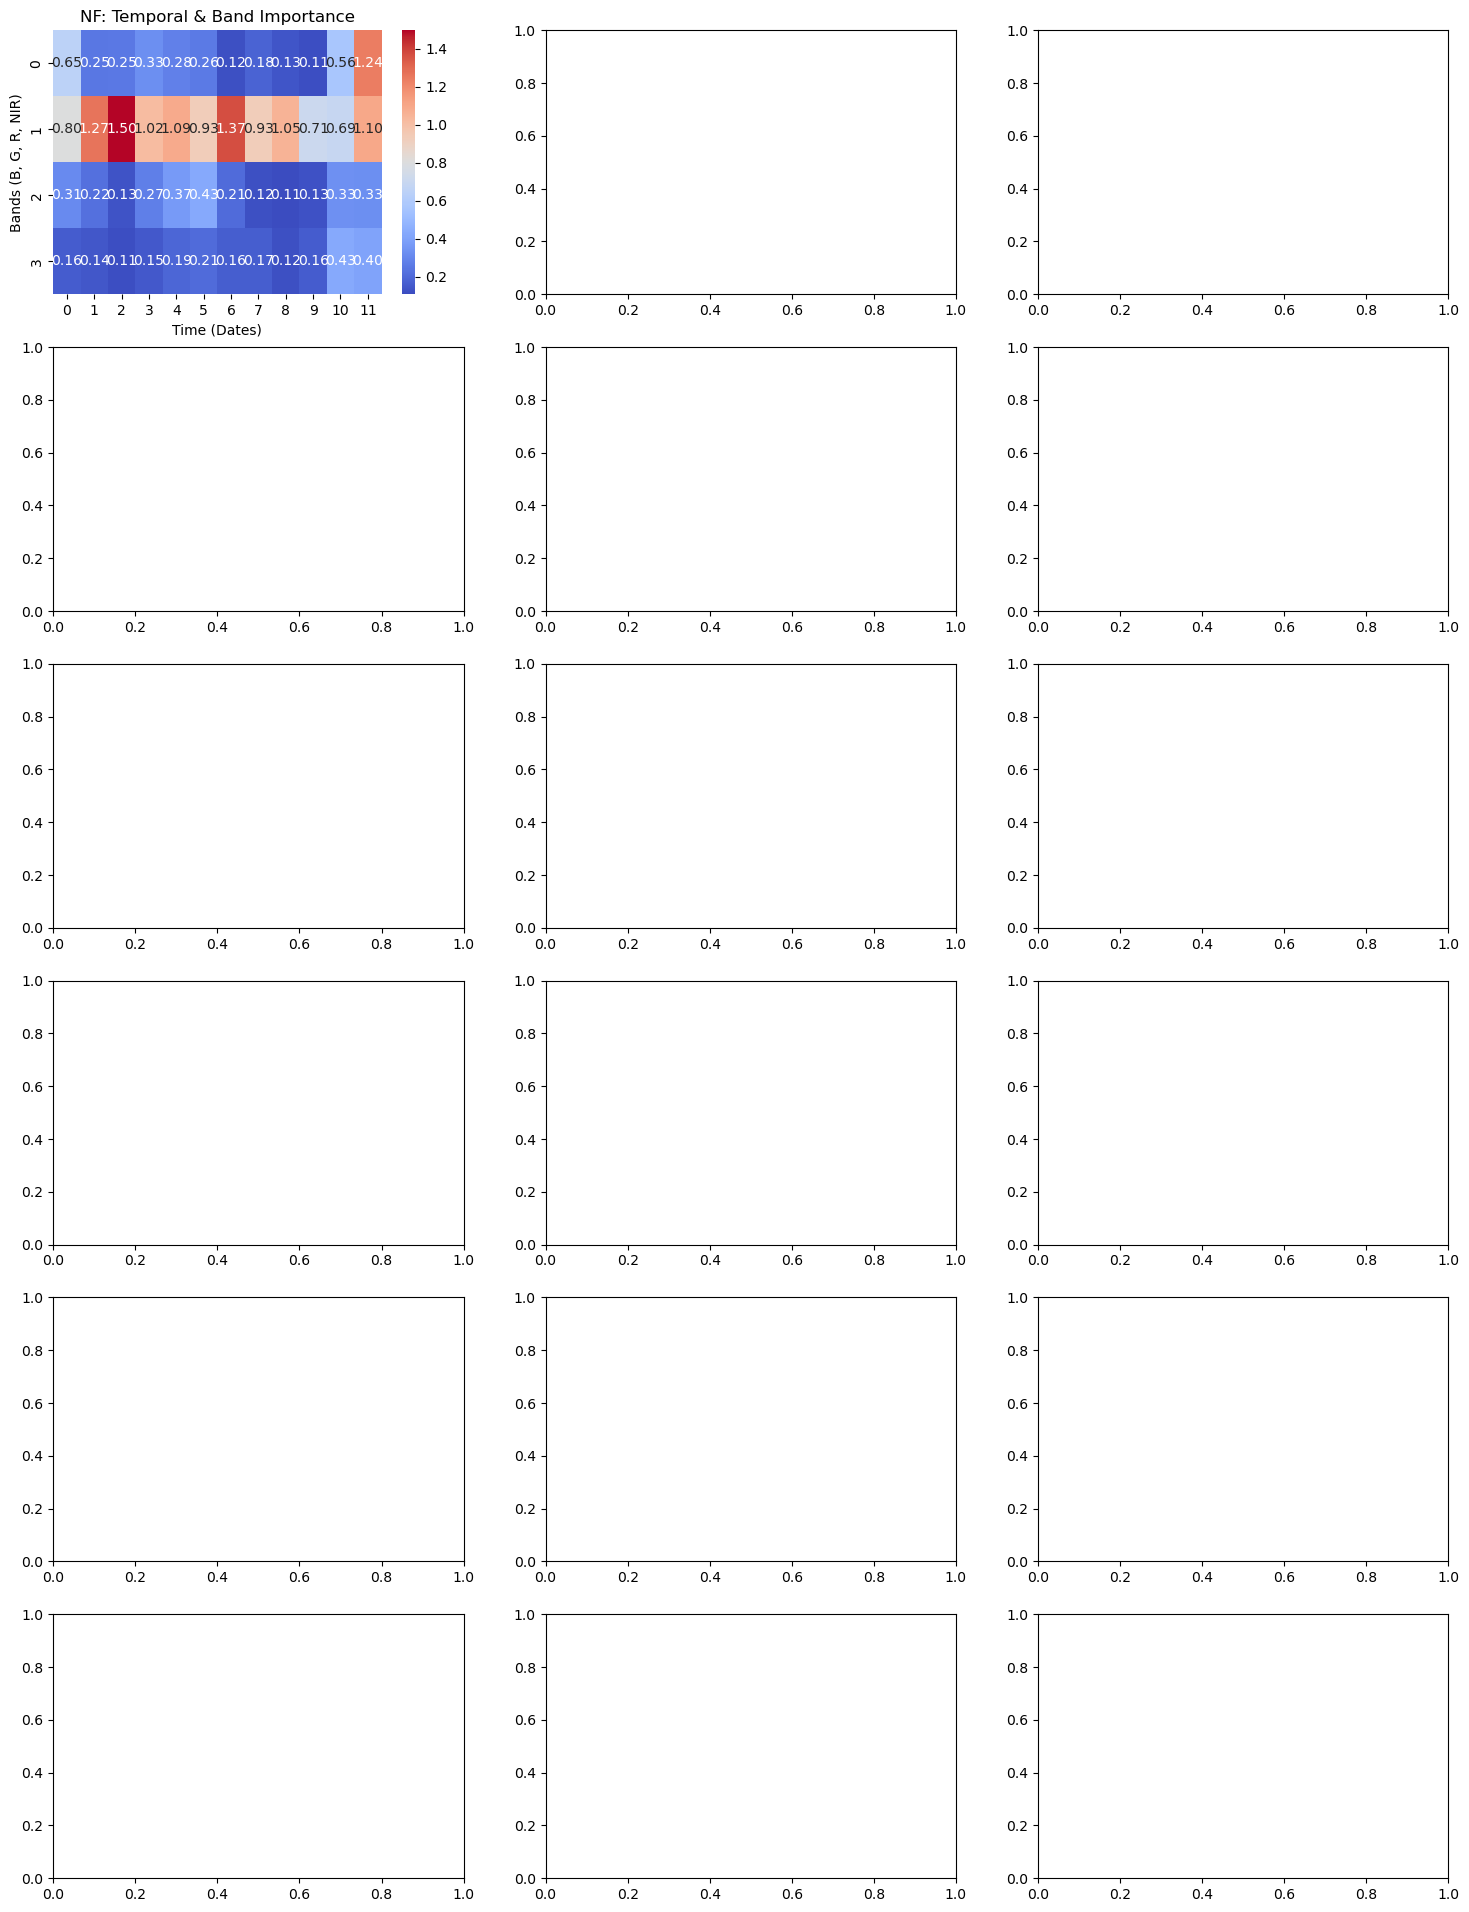

In [12]:
importance_maps, band_importance, time_importance  = psa_bands_time(model, train_loader, num_classes=6, num_repeats=5)
plot_importance_maps(importance_maps, band_importance, time_importance)

In [15]:
band_importance

array([[3.3596444 , 0.27659935, 4.96001   , 0.25767556],
       [6.7229476 , 6.076773  , 6.7929263 , 6.1291137 ],
       [6.5112615 , 4.9422317 , 4.947551  , 6.65897   ],
       [7.650862  , 6.6073627 , 6.7510424 , 7.0929914 ],
       [0.51009625, 5.416778  , 0.5080302 , 3.6762006 ],
       [5.0447636 , 6.0268817 , 4.8934364 , 5.711294  ]], dtype=float32)

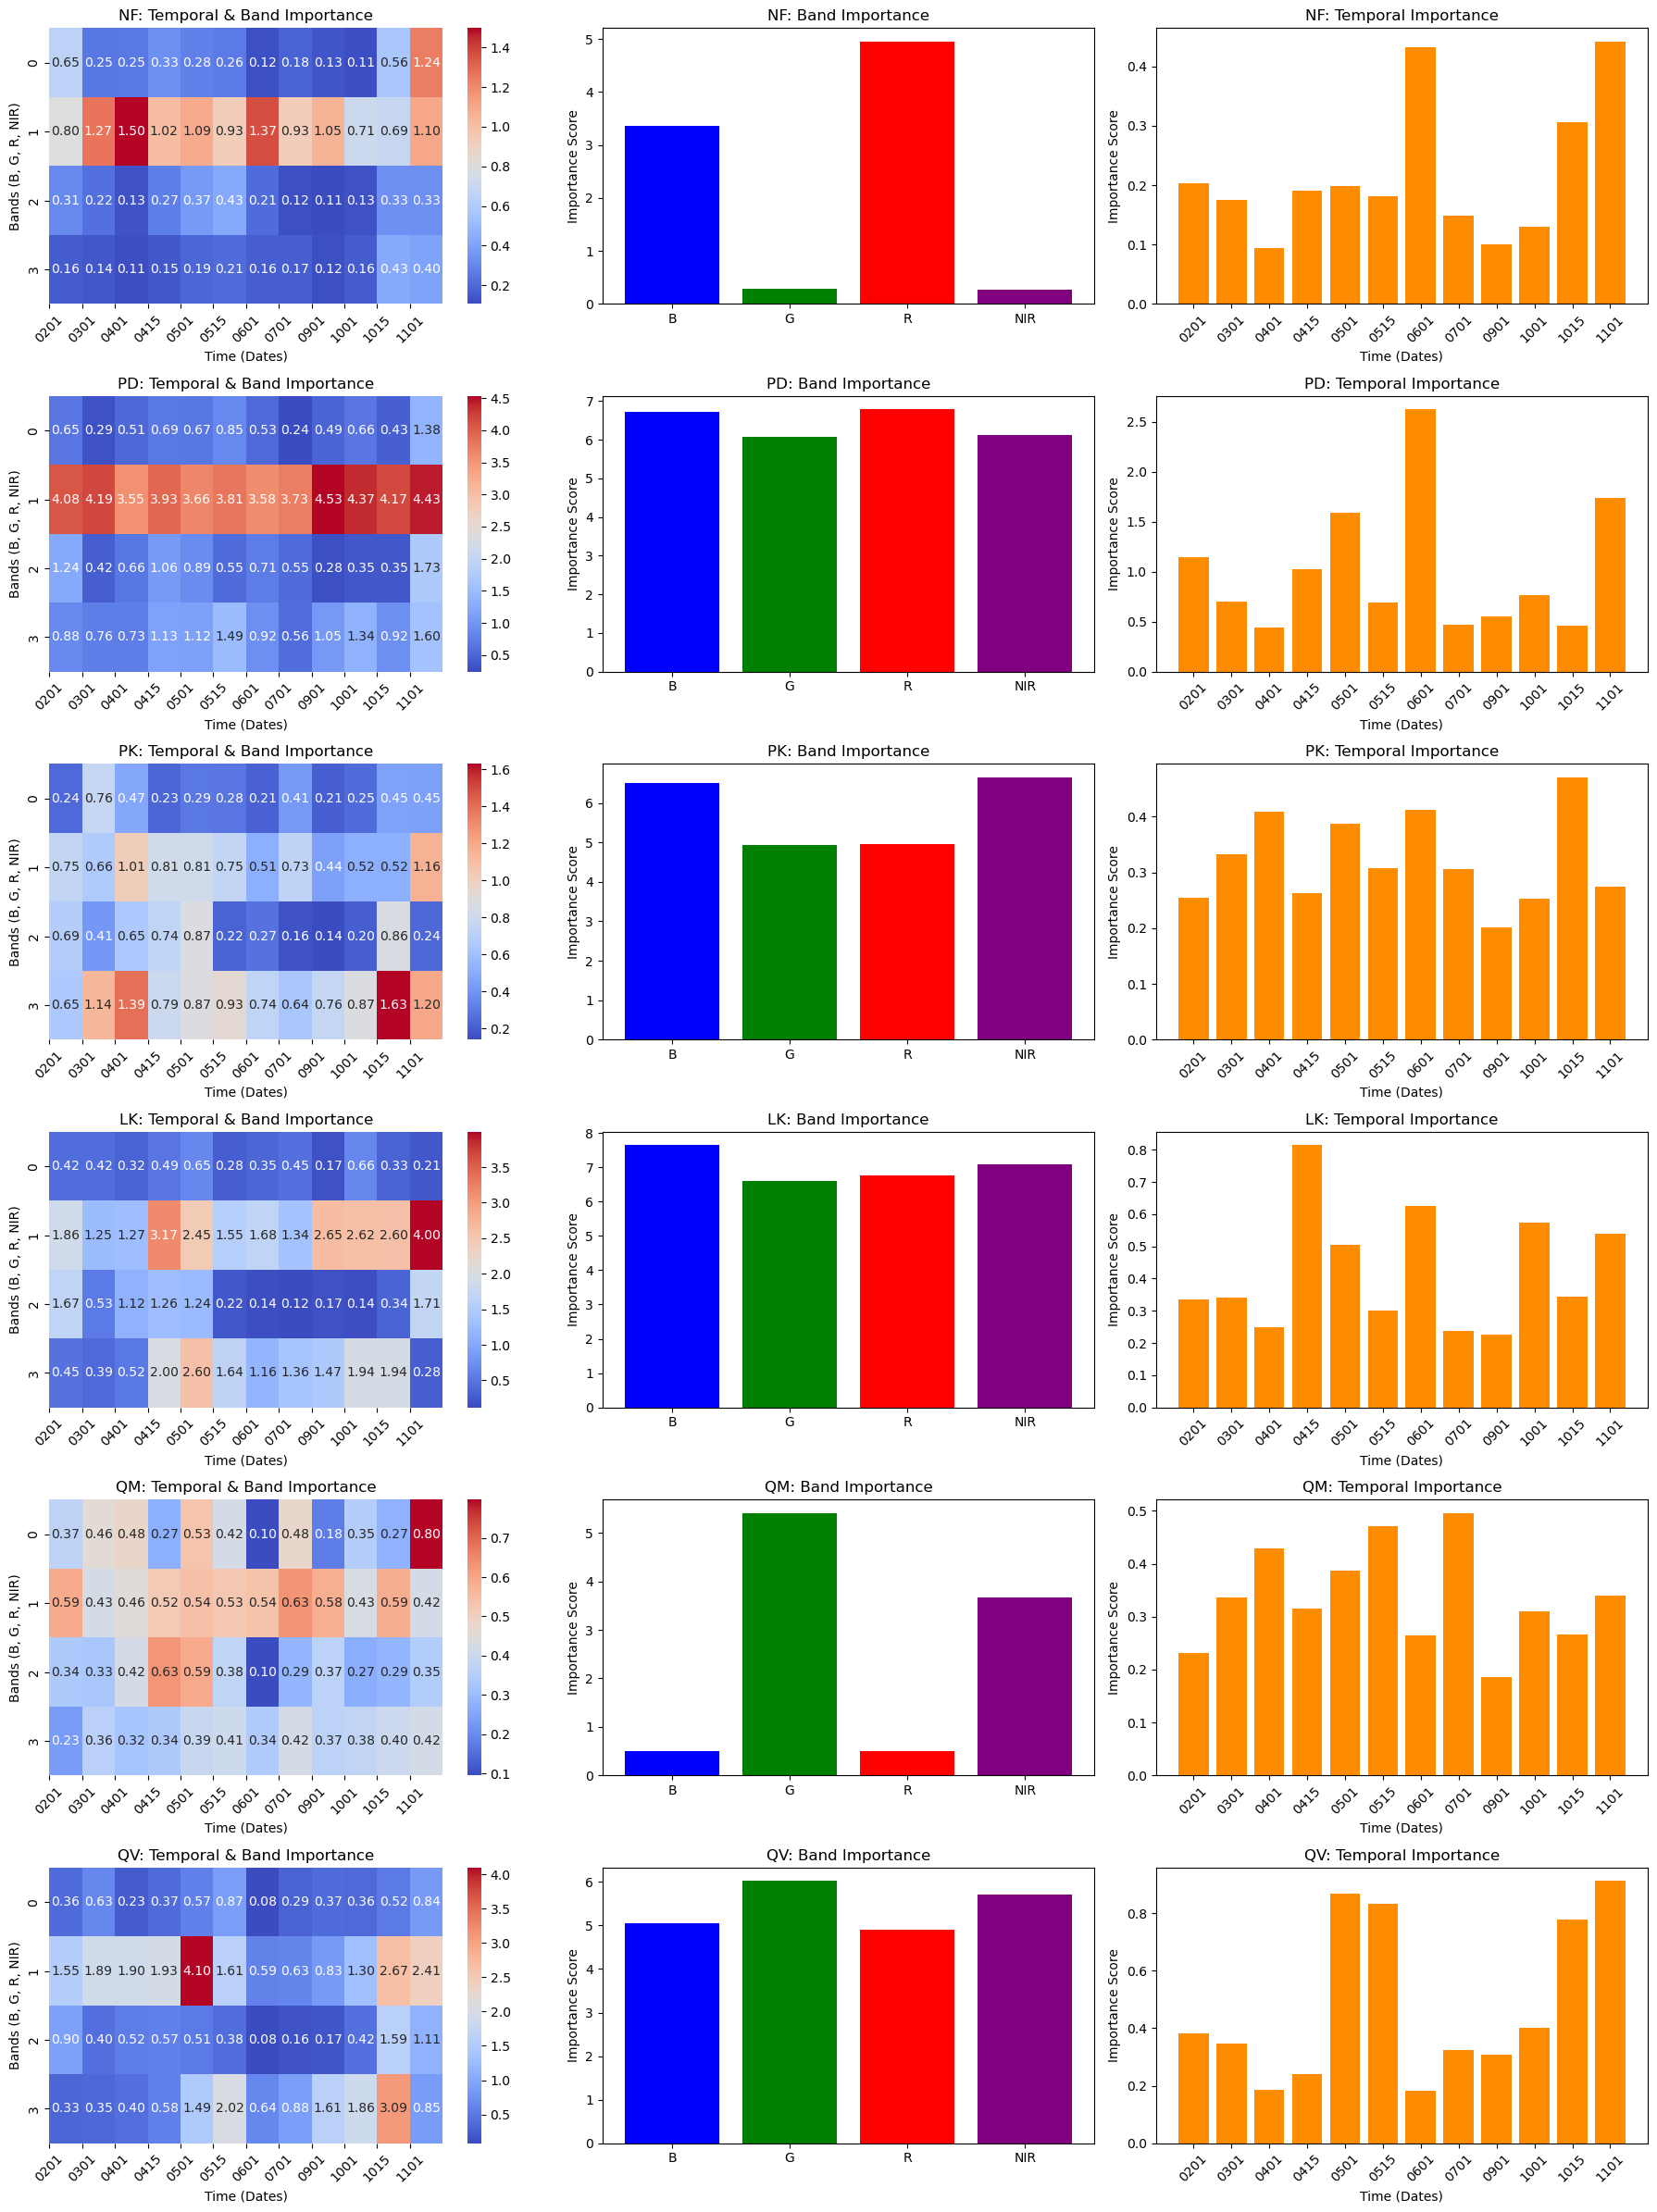

In [14]:
plot_importance_maps(importance_maps, band_importance, time_importance)

In [16]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def add_noise(data, noise_level=1.0):
    """
    데이터에 랜덤 노이즈를 추가하는 함수.

    Args:
        data (torch.Tensor): 입력 데이터 (Bands, Time, Height, Width)
        noise_level (float): 노이즈 강도 계수

    Returns:
        torch.Tensor: 노이즈가 추가된 데이터
    """
    noise = (torch.rand_like(data) * 2 - 1) * (data * noise_level)
    return data + noise

def psa_bands_time(model, dataloader, num_classes=6, num_repeats=1, perturbation_mode='zero', noise_level=1.0):
    """
    PSA 분석을 수행하여 각 밴드 및 시간 차원의 민감도를 평가하는 함수.

    Args:
        model (torch.nn.Module): 평가할 모델
        dataloader (torch.utils.data.DataLoader): 데이터 로더
        num_classes (int): 클래스 개수
        num_repeats (int): 실험 반복 횟수
        perturbation_mode (str): 교란 방식 ('zero' 또는 'noise')
        noise_level (float): 노이즈 강도 (perturbation_mode='noise'일 때만 사용)

    Returns:
        tuple: (전체 민감도 맵, 밴드 민감도, 시간 민감도)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    band, time = 4, 12  # 데이터의 밴드 수와 시간 스텝 수

    # 결과 저장 변수
    total_sensitivity_map = torch.zeros((num_classes, band, time), device=device)
    total_count_map = torch.zeros((num_classes, band, time), device=device)

    total_band_sensitivity = torch.zeros((num_classes, band), device=device)
    total_band_count = torch.zeros((num_classes, band), device=device)

    total_time_sensitivity = torch.zeros((num_classes, time), device=device)
    total_time_count = torch.zeros((num_classes, time), device=device)

    with torch.no_grad():
        for repeat in range(num_repeats):
            sensitivity_map = torch.zeros((num_classes, band, time), device=device)
            count_map = torch.zeros((num_classes, band, time), device=device)

            band_sensitivity = torch.zeros((num_classes, band), device=device)
            band_count = torch.zeros((num_classes, band), device=device)

            time_sensitivity = torch.zeros((num_classes, time), device=device)
            time_count = torch.zeros((num_classes, time), device=device)

            for data, labels in tqdm(dataloader, desc=f"Experiment {repeat+1}/{num_repeats}"):
                data, labels = data.to(device), labels.to(device)
                B, Band, Time, H, W = data.shape

                # 1. 원본 예측값 저장
                original_logits = model(data)
                original_preds = original_logits.argmax(dim=1)

                # 2. True Positive(TP) 마스크 생성
                tp_mask = (original_preds == labels)

                # 3. band & time 개별 교란
                for b in range(band):
                    for t in range(time):
                        perturbed_data = data.clone()
                        
                        if perturbation_mode == 'zero':
                            perturbed_data[:, b, t] = 0  # 완전 무효화
                        elif perturbation_mode == 'noise':
                            perturbed_data[:, b, t] = add_noise(perturbed_data[:, b, t], noise_level)

                        perturbed_logits = model(perturbed_data)
                        abs_error = torch.abs(original_logits - perturbed_logits)  # 절대값 오차 계산

                        for c in range(num_classes):
                            class_mask = (original_preds == c)
                            valid_mask = tp_mask & class_mask  # TP 중 해당 클래스 데이터 선택

                            sensitivity_map[c, b, t] += abs_error[:, c][valid_mask].sum()
                            count_map[c, b, t] += valid_mask.sum()  # TP 개수 누적

                # 4. band 전체를 교란하여 민감도 측정
                for b in range(band):
                    perturbed_data = data.clone()
                    
                    if perturbation_mode == 'zero':
                        perturbed_data[:, b] = 0  # 완전 무효화
                    elif perturbation_mode == 'noise':
                        perturbed_data[:, b] = add_noise(perturbed_data[:, b], noise_level)

                    perturbed_logits = model(perturbed_data)
                    abs_error = torch.abs(original_logits - perturbed_logits)

                    for c in range(num_classes):
                        class_mask = (original_preds == c)
                        valid_mask = tp_mask & class_mask

                        band_sensitivity[c, b] += abs_error[:, c][valid_mask].sum()
                        band_count[c, b] += valid_mask.sum()

                # 5. time 전체를 교란하여 민감도 측정
                for t in range(time):
                    perturbed_data = data.clone()
                    
                    if perturbation_mode == 'zero':
                        perturbed_data[:, :, t] = 0  # 완전 무효화
                    elif perturbation_mode == 'noise':
                        perturbed_data[:, :, t] = add_noise(perturbed_data[:, :, t], noise_level)

                    perturbed_logits = model(perturbed_data)
                    abs_error = torch.abs(original_logits - perturbed_logits)

                    for c in range(num_classes):
                        class_mask = (original_preds == c)
                        valid_mask = tp_mask & class_mask

                        time_sensitivity[c, t] += abs_error[:, c][valid_mask].sum()
                        time_count[c, t] += valid_mask.sum()

            # 반복 실험 결과 누적
            total_sensitivity_map += sensitivity_map
            total_count_map += count_map

            total_band_sensitivity += band_sensitivity
            total_band_count += band_count

            total_time_sensitivity += time_sensitivity
            total_time_count += time_count

    # **정규화 (개수로 나누기)**
    total_sensitivity_map = torch.where(total_count_map > 0, total_sensitivity_map / total_count_map, total_sensitivity_map)
    total_band_sensitivity = torch.where(total_band_count > 0, total_band_sensitivity / total_band_count, total_band_sensitivity)
    total_time_sensitivity = torch.where(total_time_count > 0, total_time_sensitivity / total_time_count, total_time_sensitivity)

    return (
        total_sensitivity_map.cpu().numpy(),  # (num_classes, band, time)
        total_band_sensitivity.cpu().numpy(),  # (num_classes, band)
        total_time_sensitivity.cpu().numpy()  # (num_classes, time)
    )

Experiment 1/1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3773/3773 [13:07<00:00,  4.79it/s]


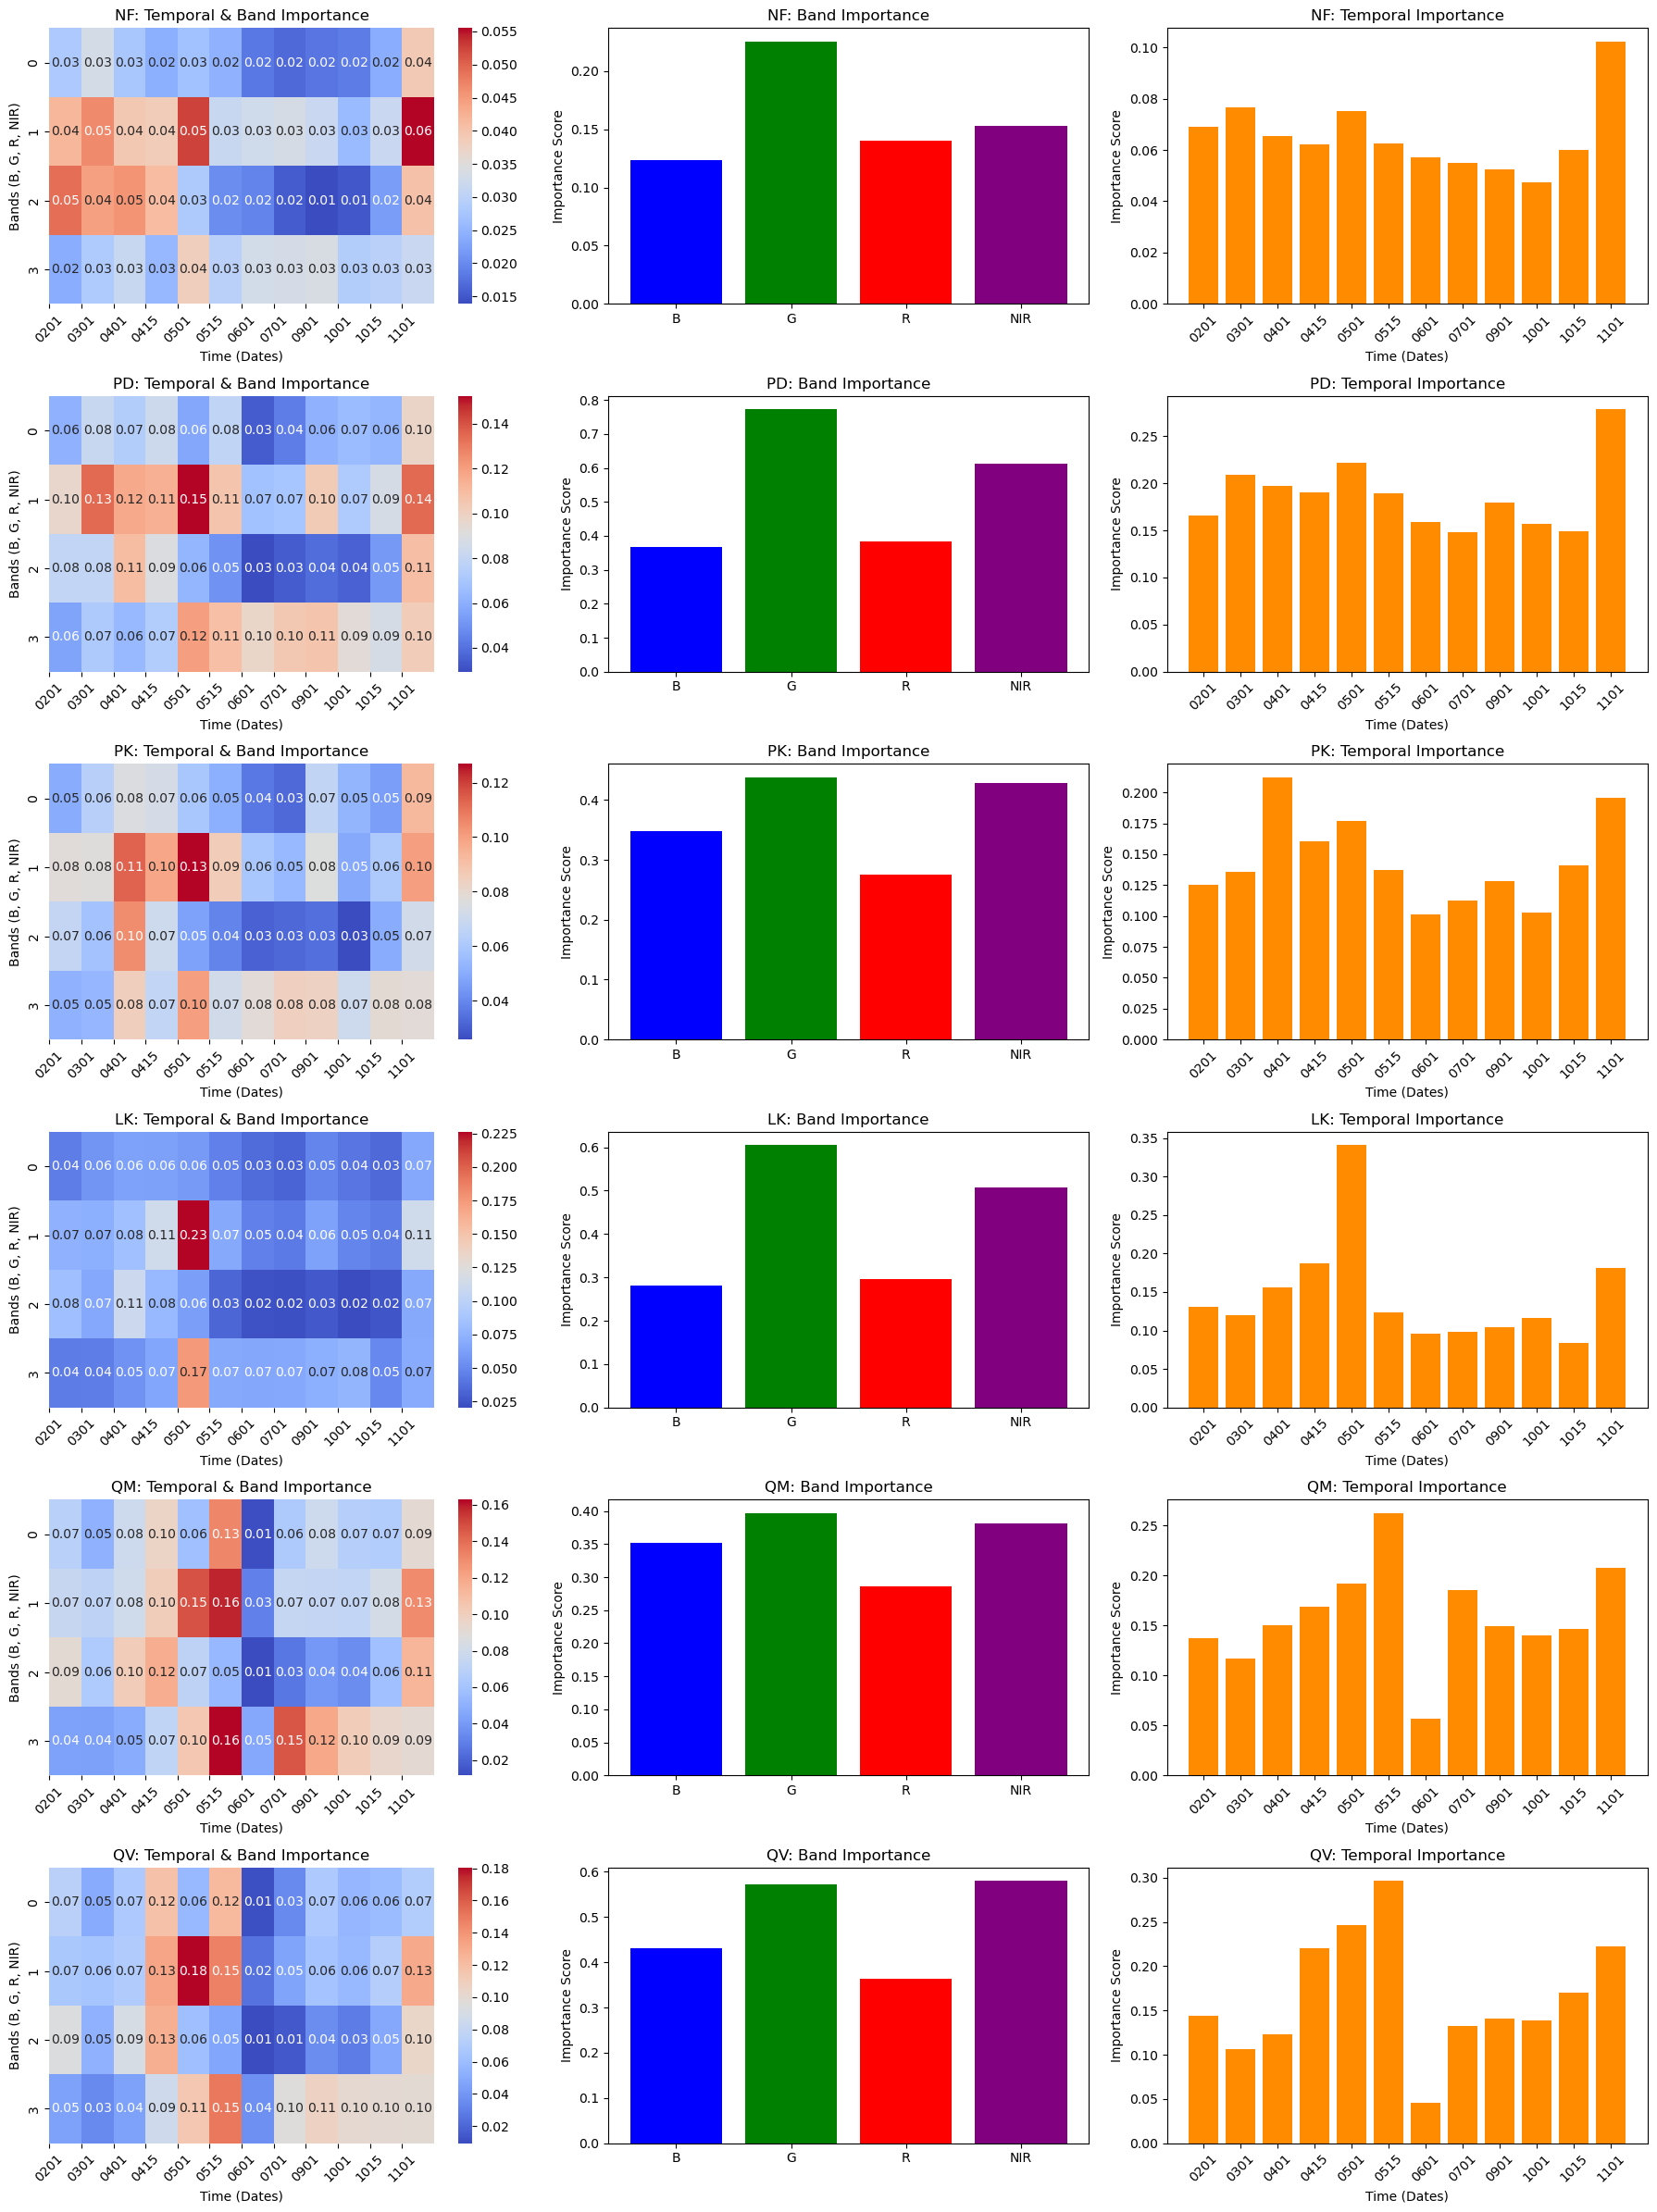

In [17]:
importance_maps, band_importance, time_importance  = psa_bands_time(model, train_loader, perturbation_mode='noise',num_classes=6, num_repeats=1)
plot_importance_maps(importance_maps, band_importance, time_importance)